<a href="https://colab.research.google.com/github/ajiaja38/Monitoring_Parking_CNN_PyTorch/blob/main/Monitoring_Parking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import pandas as pd
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Menggunakan wget untuk mengunduh dataset dari alamat URL
!wget --no-check-certificate https://cnrpark.it/dataset/CNRPark-Patches-150x150.zip

--2023-07-16 14:36:04--  https://cnrpark.it/dataset/CNRPark-Patches-150x150.zip
Resolving cnrpark.it (cnrpark.it)... 146.48.85.151
Connecting to cnrpark.it (cnrpark.it)|146.48.85.151|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 36596809 (35M) [application/zip]
Saving to: ‘CNRPark-Patches-150x150.zip’

CNRPark-Patches-150 100%[===================>]  34.90M  9.87MB/s    in 5.7s    

2023-07-16 14:36:11 (6.15 MB/s) - ‘CNRPark-Patches-150x150.zip’ saved [36596809/36596809]



In [ ]:
import zipfile,  os
zip_file = zipfile.ZipFile('/content/CNRPark-Patches-150x150.zip')
zip_file.extractall('/data/dataset/')
zip_file.close()

In [ ]:
# Path to train and val folders
base_dir = '/data/dataset/'
train_dir = Path(os.path.join(base_dir, 'train'))
validation_dir = Path(os.path.join(base_dir, 'val'))

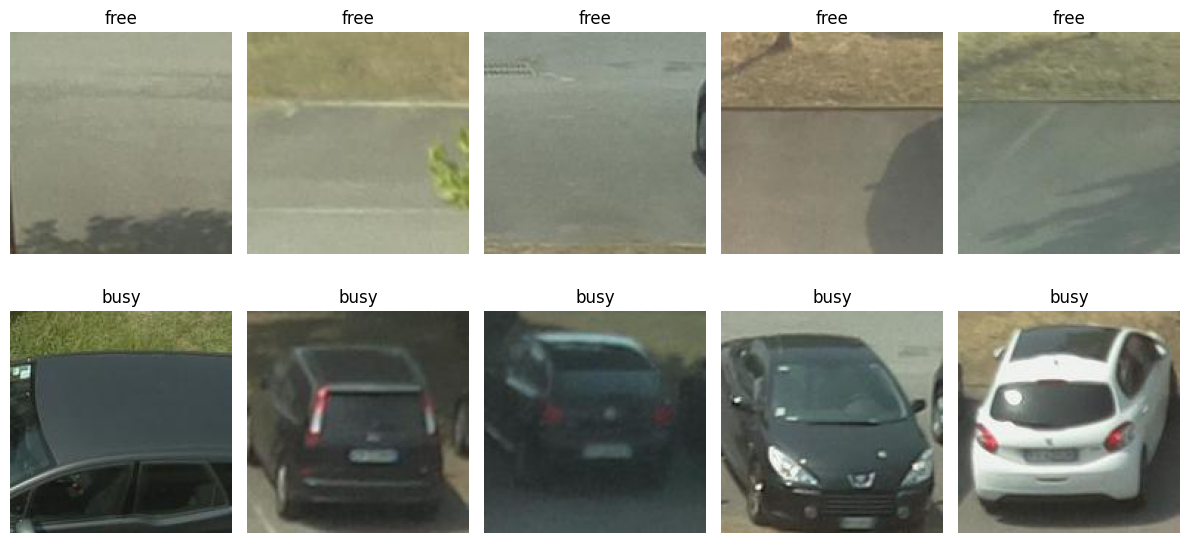

In [ ]:
# List of class names
class_names = ['free', 'busy']

# Function to plot images
def plot_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plot images for "train" dataset
train_folder = os.path.join(base_dir, 'train')
images = []
titles = []
for class_name in class_names:
    class_folder = os.path.join(train_folder, class_name)
    for i in range(5):  # Display 5 images for each class
        image_path = os.path.join(class_folder, os.listdir(class_folder)[i])
        image = Image.open(image_path)
        images.append(image)
        titles.append(class_name)

plot_images(images, titles, rows=2, cols=5)

In [ ]:
# Tambahkan rotasi hingga 30 derajat pada data pelatihan
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Gunakan transformasi yang sama untuk validasi, tetapi tanpa augmentasi
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.filepaths = []
        self.labels = []
        self.transform = transform

        for class_name in class_names:
            class_dir = os.path.join(data_dir, class_name)
            file_list = os.listdir(class_dir)
            self.filepaths.extend([os.path.join(class_dir, file) for file in file_list])
            self.labels.extend([class_name] * len(file_list))

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image = Image.open(self.filepaths[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label_tensor = torch.tensor(class_names.index(label), dtype=torch.long)

        return image, label_tensor

In [ ]:
# Create the train and validation datasets
train_dataset = CustomDataset(train_dir, transform=train_transform)
val_dataset = CustomDataset(validation_dir, transform=val_transform)

# Create the train and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Count the number of 'free' and 'busy' images in the training dataset
num_free_images_train = train_dataset.labels.count('free')
num_busy_images_train = train_dataset.labels.count('busy')

# Print the number of samples in each dataset
print("__Training Set__\n")
print(f"Number of samples in train dataset: {len(train_dataset)}")
print(f"Number of samples in free image in train dataset: {num_free_images_train}")
print(f"Number of samples in busy image in train dataset: {num_busy_images_train}")

__Training Set__

Number of samples in train dataset: 6171
Number of samples in free image in train dataset: 2550
Number of samples in busy image in train dataset: 3621


In [ ]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers to use pre-trained weights
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer with custom output layer
num_classes = 2  # Number of classes ('free' and 'busy' in this case)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 86.8MB/s]


In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary

# Print the summary of the model
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

In [ ]:
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model ke mode pelatihan

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # Print training statistics for each epoch
    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples * 100.0
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation loop
    model.eval()  # Set model ke mode evaluasi
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_inputs)
            val_batch_loss = criterion(val_outputs, val_labels)

            val_loss += val_batch_loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct_predictions += (val_predicted == val_labels).sum().item()
            val_total_samples += val_labels.size(0)

    # Calculate validation statistics for each epoch
    val_epoch_loss = val_loss / val_total_samples
    val_epoch_accuracy = val_correct_predictions / val_total_samples * 100.0
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}% - "
          f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.2f}%")

print("Training complete!")

Epoch [1/10] - Loss: 0.1509, Accuracy: 95.01% - Val Loss: 0.3802, Val Accuracy: 82.50%
Epoch [2/10] - Loss: 0.0671, Accuracy: 98.12% - Val Loss: 0.3731, Val Accuracy: 83.49%
Epoch [3/10] - Loss: 0.0530, Accuracy: 98.56% - Val Loss: 0.4099, Val Accuracy: 82.97%
Epoch [4/10] - Loss: 0.0448, Accuracy: 98.74% - Val Loss: 0.4105, Val Accuracy: 83.49%
Epoch [5/10] - Loss: 0.0358, Accuracy: 99.08% - Val Loss: 0.4004, Val Accuracy: 84.42%
Epoch [6/10] - Loss: 0.0343, Accuracy: 99.09% - Val Loss: 0.4192, Val Accuracy: 83.69%
Epoch [7/10] - Loss: 0.0314, Accuracy: 99.16% - Val Loss: 0.4008, Val Accuracy: 84.52%
Epoch [8/10] - Loss: 0.0289, Accuracy: 99.43% - Val Loss: 0.4279, Val Accuracy: 84.13%
Epoch [9/10] - Loss: 0.0313, Accuracy: 99.06% - Val Loss: 0.4418, Val Accuracy: 83.86%
Epoch [10/10] - Loss: 0.0333, Accuracy: 99.14% - Val Loss: 0.4925, Val Accuracy: 83.52%
Training complete!


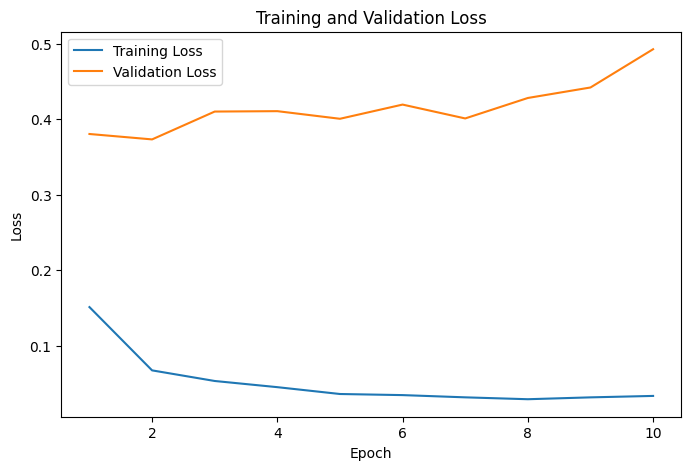

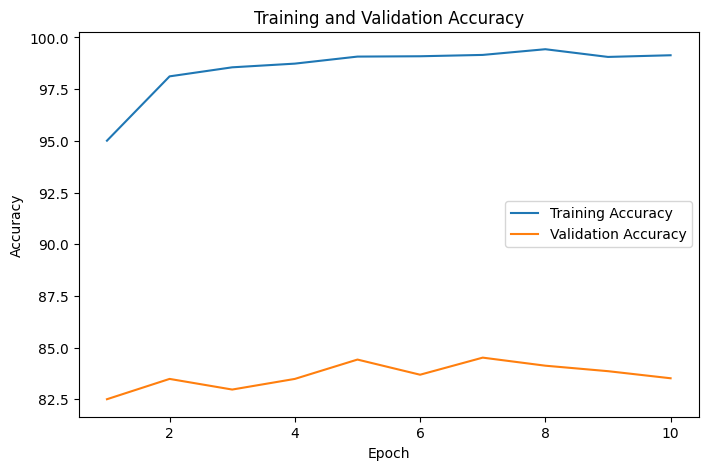

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

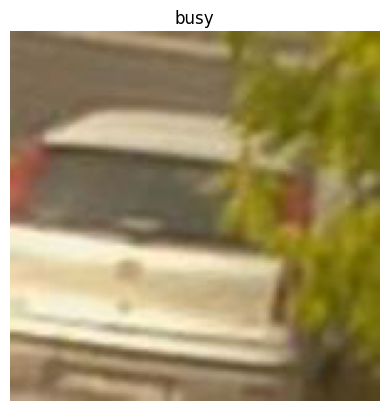

In [ ]:
preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Ubah ukuran gambar menjadi 224x224
        transforms.ToTensor(),          # Konversi gambar menjadi tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalisasi nilai piksel
    ])

# Function to predict the label
def predict_image(model, image_path):
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        return predicted.item()

test_folder = '/data/dataset/val/'

# Path to the image file
image_file = '/data/dataset/val/busy/20150708_0850_17.jpg'

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Get the full path to the image
image_path = os.path.join(test_folder, image_file)

# Predict the label for the image
prediction = predict_image(model, image_path)
if prediction == 0:
    label = 'free'
else:
    label = 'busy'

# Load and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.title(label)
plt.axis('off')
plt.show()